### Kaggle Data Science BOWL 2017 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import cv2
import h5py
import scipy.ndimage as ndimage
from sklearn.cross_validation import KFold
from skimage import measure, morphology, segmentation
#from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import dicom
%matplotlib inline
p = sns.color_palette()
import time

# get package versions
def get_version(*vars):
    for var in vars:
        module = __import__(var)    
        print '%s: %s' %(var,module.__version__)
    
# package version    
get_version('numpy','matplotlib','cv2','sklearn','skimage','scipy','h5py')

numpy: 1.11.2
matplotlib: 1.5.1
cv2: 3.1.0
sklearn: 0.18.1
skimage: 0.12.3
scipy: 0.18.1
h5py: 2.6.0


/home/mra/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### presets

In [2]:
#path2data='../sample_images/'
#path2data='../stage1/'
path2data='/media/mra/My Passport/Kaggle/datascience2017/stage1/'
patients=os.listdir(path2data)
patients.sort()
print 'total subjects: %s' %(len(patients))

path2output='./output/data/'

# dispaly
display_ena=False

# resize
h,w=512,512

total subjects: 1595


### Functions

In [3]:
# Load dicom files
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    #image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def array_stats(X):
    X=np.asarray(X)
    print 'array shape: ',X.shape, X.dtype
    #print 'min: %.3f, max:%.3f, avg: %.3f, std:%.3f' %(np.min(X),np.max(X),np.mean(X),np.std(X))
    print 'min: {}, max: {}, avg: {:.3}, std:{:.3}'.format( np.min(X),np.max(X),np.mean(X),np.std(X))
    


# stack images and labels
def stack_data(df,indices,(h,w)):
    X=[]
    Y=[]
    y=[]
    for r in (indices):
        # get patinet id and cancer status
        p_id=df_train.id[r] # patient id
        p_c=df_train.cancer[r] # patinet cancer

        # load scan
        scan=load_scan(path2data+p_id)
        X1 = get_pixels_hu(scan)
        nb_slices=len(X1)
        N,H,W=X1.shape
        
        # get lung segmentation
        #print 'wait ....'
        Y1=np.zeros_like(X,'uint8')
        for slice_nm in range(len(X1)):
            masks=seperate_lungs(X[slice_nm])
            Y1[slice_nm]=masks[1]
        
        # resize
        if h<H:
            Xr=np.zeros((nb_slices,h,w),dtype=X1.dtype)
            Yr=np.zeros((nb_slices,h,w),dtype=Y1.dtype)
            for k1 in range(nb_slices):
                Xr[k1]=cv2.resize(X1[k1], (w, h), interpolation=cv2.INTER_CUBIC)
                Yr[k1]=cv2.resize(Y1[k1], (w, h), interpolation=cv2.INTER_CUBIC)
        else:
            Xr=X1
            Yr=Y1
        print 'patient %s id: %s, cancer: %s, nb slices: %s' %(r,p_id,p_c,Xr.shape[0])        
        X.append(Xr)
        Y.append(Yr)
        y.append(p_c)
    return X,y  

### Get data stats

wait ...
array shape:  (1595,) int64
min: 94, max: 541, avg: 1.79e+02, std:67.0
Total patients 1595 Total DCM files 285380


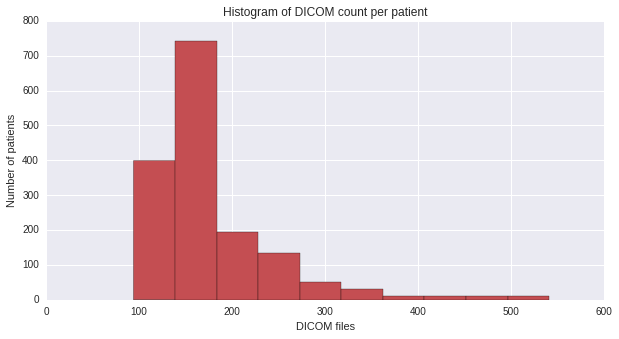

In [4]:
print 'wait ...'
nb_dicoms=[]
for d in patients:
    #print("Patient '{}' has {} scans".format(d, len(os.listdir(path2data + d))))
    nb_dicoms.append(len(os.listdir(path2data + d)))

array_stats(nb_dicoms)    
print('Total patients {} Total DCM files {}'.format(len(patients), len(glob.glob(path2data+'*/*.dcm'))))

plt.figure(figsize=((10,5)))
plt.hist(nb_dicoms, color=p[2])
plt.ylabel('Number of patients')
plt.xlabel('DICOM files')
plt.title('Histogram of DICOM count per patient')
plt.show()

### Training stats

In [5]:
df_train = pd.read_csv('../stage1_labels.csv')
print('Number of training patients: {}'.format(len(df_train)))
print('Cancer rate: {:.4}%'.format(df_train.cancer.mean()*100))
df_train.head()


Number of training patients: 1397
Cancer rate: 25.91%


,id,cancer
0,0015ceb851d7251b8f399e39779d1e7d,1
1,0030a160d58723ff36d73f41b170ec21,0
2,003f41c78e6acfa92430a057ac0b306e,0
3,006b96310a37b36cccb2ab48d10b49a3,1
4,008464bb8521d09a42985dd8add3d0d2,1


## sample patinet with cancer

patient id: 0015ceb851d7251b8f399e39779d1e7d, cancer: 1
array shape:  (195, 512, 512) int16
min: -3024, max: 3071, avg: -1.06e+03, std:1.12e+03


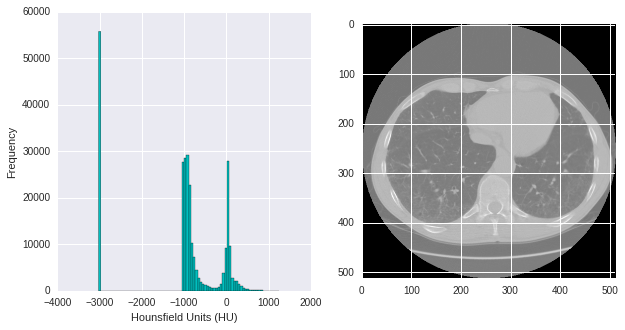

In [6]:
r=0 # row

# get patinet id and cancer status
p_id=df_train.id[r] # patient id
p_c=df_train.cancer[r] # patinet cancer
print 'patient id: %s, cancer: %s' %(p_id,p_c)

# load scan
scan=load_scan(path2data+p_id)
X = get_pixels_hu(scan)
array_stats(X)

sn=70
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(X[sn].flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")

# Show some slice in the middle
plt.subplot(1,2,2)
plt.imshow(X[sn], cmap=plt.cm.gray)
plt.show()

In [7]:
if display_ena is True:
    nb_slices=len(X)
    r,c=nb_slices/5,5
    f, plots = plt.subplots(r, c, sharex='all', sharey='all', figsize=(c*3, r*3))
    print 'wait ...'
    for i in range(nb_slices):
        plots[i // c, i % c].axis('off')
        plots[i // c, i % c].imshow(X[i], cmap=plt.cm.bone)

In [8]:
if display_ena is True:
    nb_slices=len(X)
    r,c=nb_slices/5,5
    f, plots = plt.subplots(r, c, sharex='all', sharey='all', figsize=(c*3, r*3))
    print 'wait ...'
    for i in range(nb_slices):
        plots[i // c, i % c].axis('off')
        plots[i // c, i % c].imshow(Y1[i], cmap=plt.cm.bone)

## sample patinet non-cancer

patient id: 0030a160d58723ff36d73f41b170ec21, cancer: 0
array shape:  (265, 512, 512) int16
min: -3024, max: 3072, avg: -9.51e+02, std:1.15e+03


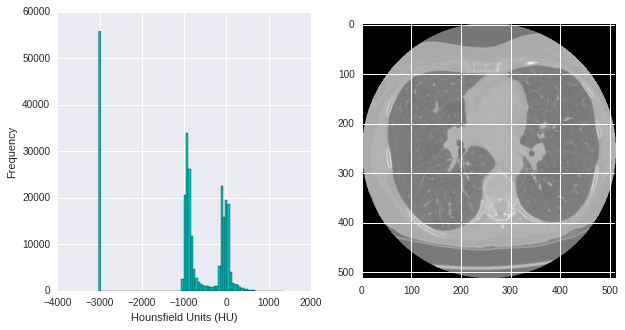

In [9]:
r=1 # row

# get patinet id and cancer status
p_id=df_train.id[r] # patient id
p_c=df_train.cancer[r] # patinet cancer
print 'patient id: %s, cancer: %s' %(p_id,p_c)

# load scan
scan=load_scan(path2data+p_id)
X = get_pixels_hu(scan)
array_stats(X)

sn=len(X)/2
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(X[sn].flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")

# Show some slice in the middle
plt.subplot(1,2,2)
plt.imshow(X[sn], cmap=plt.cm.gray)
plt.show()

## save as HDF5

In [10]:
start_time=time.time()

# total subjects
nb_sbj=len(df_train)

h,w=512,512

# create h5 file
f=h5py.File(path2output+'dsb.hdf5','w-')

for p,p_id in enumerate(df_train.id):
    
    # get patinet id and cancer status
    #p_id=df_train.id[p] # patient id
    print 'processing patient %s,%s, wait ...' %(p,p_id)
    y=df_train.cancer[p].astype('uint8') # patinet cancer

    # load scan
    scan=load_scan(path2data+p_id)
    X = get_pixels_hu(scan)
    nb_slices=len(X)
    N,H,W=X.shape
        
    array_stats(X)
    #array_stats(y)
    #print '-'*50

    # store X,y
    f[p_id]=X
    dset=f[p_id]
    dset.attrs['cancer']=y
    
    #print 'patient %s saved' %p 
    print '-' *50

f.close()    
elapsed_time=(time.time()-start_time)
print ('elapsed time: %.2d sec' %(elapsed_time))        

processing patient 0,0015ceb851d7251b8f399e39779d1e7d, wait ...
array shape:  (195, 512, 512) int16
min: -3024, max: 3071, avg: -1.06e+03, std:1.12e+03
--------------------------------------------------
processing patient 1,0030a160d58723ff36d73f41b170ec21, wait ...
array shape:  (265, 512, 512) int16
min: -3024, max: 3072, avg: -9.51e+02, std:1.15e+03
--------------------------------------------------
processing patient 2,003f41c78e6acfa92430a057ac0b306e, wait ...
array shape:  (233, 512, 512) int16
min: -1024, max: 2002, avg: -4.14e+02, std:4.68e+02
--------------------------------------------------
processing patient 3,006b96310a37b36cccb2ab48d10b49a3, wait ...
array shape:  (173, 512, 512) int16
min: -1024, max: 2026, avg: -4.94e+02, std:5.02e+02
--------------------------------------------------
processing patient 4,008464bb8521d09a42985dd8add3d0d2, wait ...
array shape:  (146, 512, 512) int16
min: -3024, max: 3071, avg: -9.77e+02, std:1.14e+03
------------------------------------

## Verify

In [14]:
# create h5 file
f2=h5py.File(path2output+'dsb.hdf5','r')
print len(f2.keys())
X1=f2[f2.keys()[10]]
array_stats(X1)


1397
array shape:  (217, 512, 512) int16
min: -1000, max: 2015, avg: -3.91e+02, std:4.93e+02


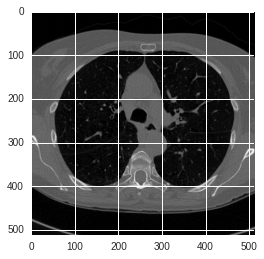

In [17]:
plt.imshow(X1[70],cmap='gray')